In [2]:
from deepface import DeepFace
from matplotlib import pyplot as plt
import cv2
import numpy as np
import mediapipe as mp
import supervision as sv

## Getting the reference image

In [227]:
face_objs = DeepFace.extract_faces(
    img_path="reference_image.jpg",
    detector_backend="opencv",
    align=False,
    normalize_face=False,
    color_face="bgr",
  )

In [228]:
OUTPUT_SIZE = (200, 200)

def fit_to_output_size(frame: np.ndarray) -> np.ndarray:
    """
    Resize a frame to the output size.
    """
    return cv2.resize(frame, OUTPUT_SIZE)

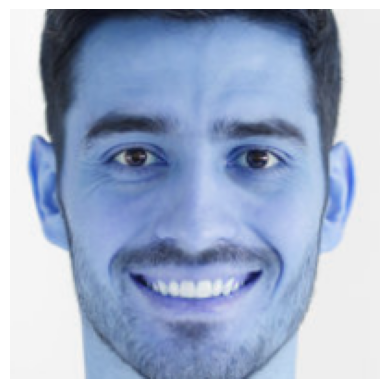

In [229]:
face = face_objs[0]["face"]
frame = fit_to_output_size(face)

plt.imshow(frame)
plt.axis('off')

plt.show()

In [230]:
VERTEX_COLOR = sv.Color.WHITE
VERTEX_RADIUS = 1

model = mp.solutions.face_mesh.FaceMesh(
    static_image_mode=False,       # Set to True if working with still images
    # refine_landmarks=True,         # Enables more precise landmark detection (includes irises)
    max_num_faces=1,               # Number of faces to detect
    min_detection_confidence=0.5,  # Minimum detection confidence
    min_tracking_confidence=0.5,   # Minimum tracking confidence
)
annotator = sv.VertexAnnotator(color=VERTEX_COLOR, radius=VERTEX_RADIUS)

In [231]:
resolution_wh = (frame.shape[1], frame.shape[0])
processed_frame = model.process(frame)
key_points = sv.KeyPoints.from_mediapipe(processed_frame, resolution_wh)

In [232]:
def get_xyz_from_processed_frame(processed_frame):
    results = [
                face_landmark.landmark
                for face_landmark in processed_frame.multi_face_landmarks
            ]

    xyz = []
    for pose in results:
        prediction_xyz = []
        prediction_confidence = []
        for landmark in pose:
            keypoint_xyz = [
                landmark.x,
                landmark.y,
                landmark.z,  # z-coordinate (relative to camera in meters) scaled to image width
            ]
            prediction_xyz.append(keypoint_xyz)
            prediction_confidence.append(landmark.visibility)

        xyz.append(prediction_xyz)

    return xyz

In [233]:
def get_scaled_xy_from_xyz(xyz, resolution_wh):
    xy = []
    for (x, y, z) in xyz:
        xy.append([
            x * resolution_wh[0],
            y * resolution_wh[1],
        ])

    return np.array(xy)

In [235]:
get_xyz_from_processed_frame(processed_frame)

[[[0.5042639970779419, 0.7085892558097839, -0.07760970294475555],
  [0.5063985586166382, 0.6354734897613525, -0.18203185498714447],
  [0.5048086643218994, 0.6588018536567688, -0.098546601831913],
  [0.48010218143463135, 0.5132945775985718, -0.14330442249774933],
  [0.5069073438644409, 0.5993248224258423, -0.19389235973358154],
  [0.5066449642181396, 0.5497214794158936, -0.18270881474018097],
  [0.5053327083587646, 0.42957770824432373, -0.09970571845769882],
  [0.2811504006385803, 0.4165991246700287, 0.023249885067343712],
  [0.5049687623977661, 0.3469509482383728, -0.0768091082572937],
  [0.5053002238273621, 0.3012438714504242, -0.08334575593471527],
  [0.5060114860534668, 0.13358134031295776, -0.06072691082954407],
  [0.504107654094696, 0.7215364575386047, -0.07252299785614014],
  [0.5037206411361694, 0.7278180122375488, -0.06497722864151001],
  [0.5034971237182617, 0.7254356145858765, -0.0529116727411747],
  [0.5039718151092529, 0.7978972792625427, -0.029334746301174164],
  [0.504044

In [236]:
np.save('key_points_xyz.npy', get_xyz_from_processed_frame(processed_frame))

In [237]:
loaded_key_points = np.load('key_points_xyz.npy')
print(loaded_key_points)

[[[ 0.504264    0.70858926 -0.0776097 ]
  [ 0.50639856  0.63547349 -0.18203185]
  [ 0.50480866  0.65880185 -0.0985466 ]
  ...
  [ 0.55477828  0.43339923 -0.03274956]
  [ 0.72490138  0.40131801  0.03281721]
  [ 0.74185407  0.39269117  0.0342879 ]]]


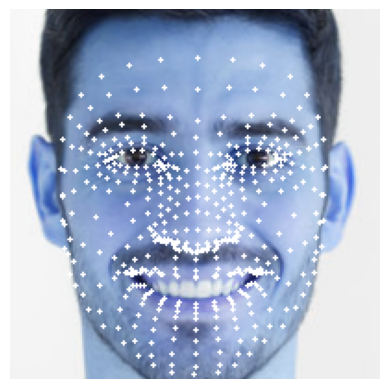

In [238]:
out_frame = annotator.annotate(frame, key_points)

plt.imshow(out_frame)
plt.axis('off')

plt.show()

## Get the face for frontalization

In [410]:
face_objs = DeepFace.extract_faces(
    img_path="test_image3.jpg",
    detector_backend="opencv",
    align=False,
    normalize_face=False,
    color_face="bgr",
  )

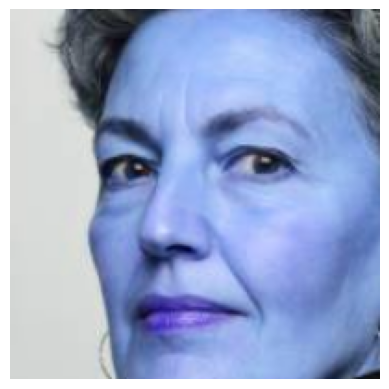

In [411]:
face = face_objs[0]["face"]
frame = fit_to_output_size(face)

plt.imshow(frame)
plt.axis('off')

plt.show()

In [412]:
resolution_wh = (frame.shape[1], frame.shape[0])
processed_frame = model.process(frame)
key_points = sv.KeyPoints.from_mediapipe(processed_frame, resolution_wh)
key_points.xy = key_points.xy[:1]

In [413]:
image_to_frontalize_xyz = get_xyz_from_processed_frame(processed_frame)
image_to_frontalize_xyz

[[[0.4141879677772522, 0.770233154296875, -0.10000979900360107],
  [0.37781643867492676, 0.643253743648529, -0.17176605761051178],
  [0.4133493900299072, 0.6842730045318604, -0.09509458392858505],
  [0.37957334518432617, 0.5288769006729126, -0.10970278829336166],
  [0.3755035698413849, 0.6068630218505859, -0.18117226660251617],
  [0.38725894689559937, 0.5614190101623535, -0.16647689044475555],
  [0.43096232414245605, 0.44832757115364075, -0.07463495433330536],
  [0.2719973027706146, 0.44003593921661377, 0.15692360699176788],
  [0.4437830150127411, 0.35261309146881104, -0.04702998697757721],
  [0.44244125485420227, 0.3025473952293396, -0.05040673166513443],
  [0.4637928009033203, 0.1289781630039215, -0.0065794410184025764],
  [0.4161537289619446, 0.7887070178985596, -0.09603700786828995],
  [0.42170271277427673, 0.803852915763855, -0.0855618342757225],
  [0.429201602935791, 0.8106569051742554, -0.07144760340452194],
  [0.4294901192188263, 0.8225431442260742, -0.062315504997968674],
  [0

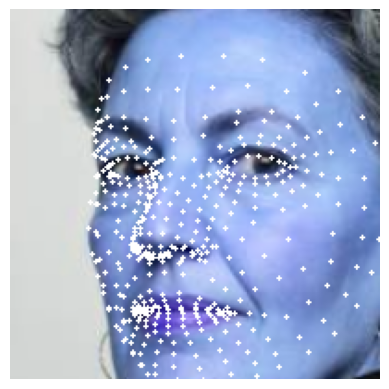

In [414]:
out_frame = annotator.annotate(frame, key_points)

plt.imshow(out_frame)
plt.axis('off')

plt.show()

## Frontalization

In [415]:
face_to_frontalize_keypoints = np.array(image_to_frontalize_xyz)
reference_keypoints = np.load('key_points_xyz.npy')

print("Shape of face_to_frontalize_keypoints:", face_to_frontalize_keypoints.shape)
print("Shape of reference_keypoints:", reference_keypoints.shape)

Shape of face_to_frontalize_keypoints: (1, 468, 3)
Shape of reference_keypoints: (1, 468, 3)


### AffinePartial3D

In [377]:
# Estimate the affine transformation
retval, matrix, inliers = cv2.estimateAffine3D(face_to_frontalize_keypoints[0], reference_keypoints[0])
frontalized_keypoints = cv2.transform(face_to_frontalize_keypoints, matrix)[0]

### Procrustes Analysis

In [416]:
def procrustes_analysis(X, Y):
    """
    Perform Procrustes analysis to align X to Y.
    X and Y are expected to have shape (N, 3) where N is the number of keypoints.
    """
    # Subtract the centroid (mean) of the points
    X_mean = np.mean(X, axis=0)
    Y_mean = np.mean(Y, axis=0)
    
    X_centered = X - X_mean
    Y_centered = Y - Y_mean
    
    # Normalize the points (scaling to unit variance)
    X_norm = np.linalg.norm(X_centered)
    Y_norm = np.linalg.norm(Y_centered)
    
    X_centered /= X_norm
    Y_centered /= Y_norm
    
    # Compute the optimal rotation matrix using SVD
    U, _, Vt = np.linalg.svd(np.dot(X_centered.T, Y_centered))
    R = np.dot(U, Vt)
    
    # Apply the rotation matrix to X
    X_aligned = np.dot(X_centered, R)
    
    # Rescale and shift X_aligned back to original scale and position
    X_aligned = X_aligned * Y_norm + Y_mean
    
    return X_aligned

frontalized_keypoints = procrustes_analysis(face_to_frontalize_keypoints[0], reference_keypoints[0])

## Frontalized visualization

In [417]:
frontalized_keypoints = get_scaled_xy_from_xyz(frontalized_keypoints, resolution_wh)
face_to_frontalize_keypoints = get_scaled_xy_from_xyz(face_to_frontalize_keypoints[0], resolution_wh)
reference_keypoints = get_scaled_xy_from_xyz(reference_keypoints[0], resolution_wh)

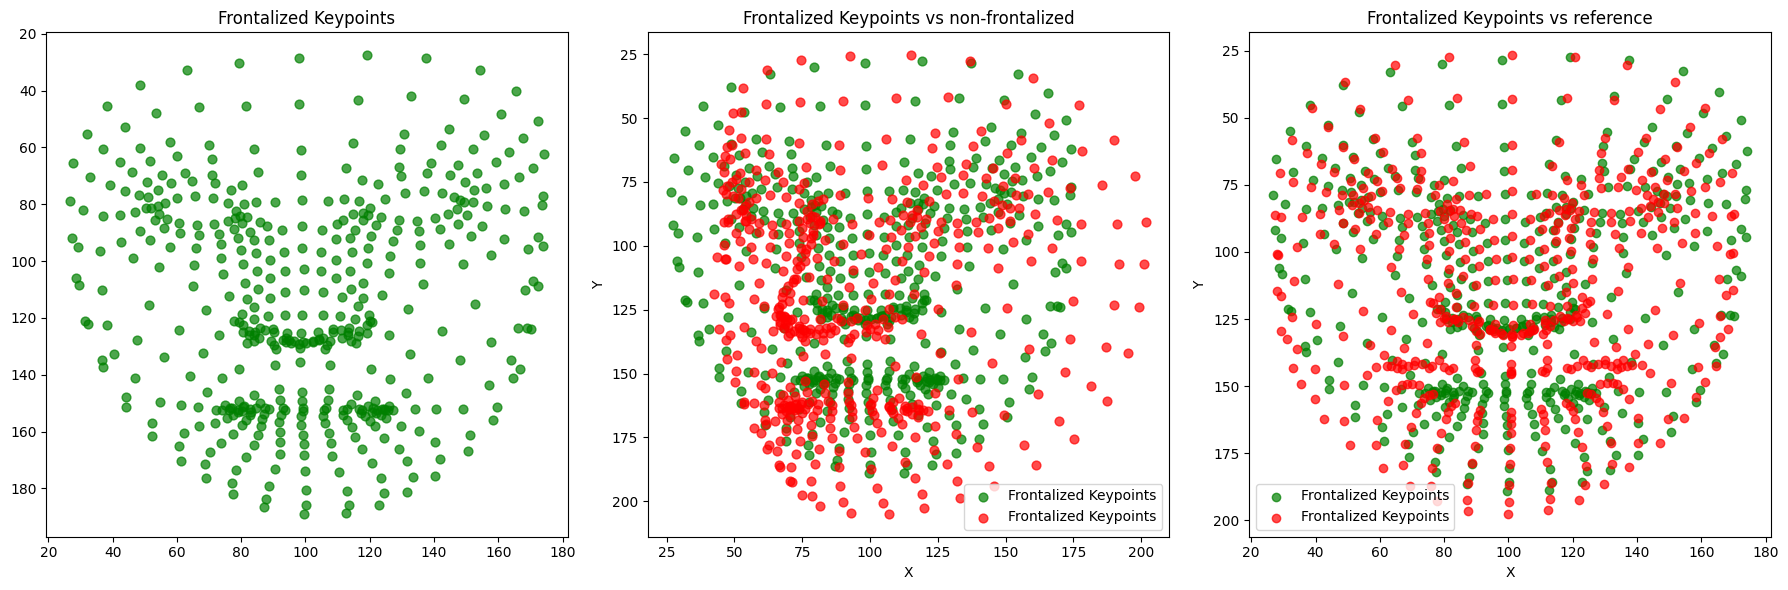

In [418]:
# Create a figure with 1 row and 3 columns for subplots
plt.figure(figsize=(18, 6))  # Adjust the figure size for better spacing

# Just frontalized
plt.subplot(1, 3, 1)
plt.scatter(frontalized_keypoints[:, 0], frontalized_keypoints[:, 1], 
            color='green', label='Frontalized Keypoints', alpha=0.7, s=40)

plt.title(f'Frontalized Keypoints')
plt.gca().invert_yaxis()  # Invert Y-axis to match image coordinates

# Frontalized vs non-frontalized
plt.subplot(1, 3, 2)
plt.scatter(frontalized_keypoints[:, 0], frontalized_keypoints[:, 1], 
            color='green', label='Frontalized Keypoints', alpha=0.7, s=40)

plt.scatter(face_to_frontalize_keypoints[:, 0], face_to_frontalize_keypoints[:, 1], 
            color='red', label='Frontalized Keypoints', alpha=0.7, s=40)

plt.title(f'Frontalized Keypoints vs non-frontalized')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.gca().invert_yaxis()  # Invert Y-axis to match image coordinates

# Frontalized vs Reference
plt.subplot(1, 3, 3)
plt.scatter(frontalized_keypoints[:, 0], frontalized_keypoints[:, 1], 
            color='green', label='Frontalized Keypoints', alpha=0.7)

plt.scatter(reference_keypoints[:, 0], reference_keypoints[:, 1], 
            color='red', label='Frontalized Keypoints', alpha=0.7)

plt.title(f'Frontalized Keypoints vs reference')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.gca().invert_yaxis()  # Invert Y-axis to match image coordinates

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()